<a href="https://colab.research.google.com/github/ejf78/cdc_vitalsigns/blob/master/Vital_Signs_Functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About This Notebook

This notebook contains functions for wrangling and visualizing BNIA's Baltimore vital sign indicators. The data has already been preprocessed to a standardized format. For more information, visit BNIA's [vital signs page](https://bniajfi.org/vital_signs/). 

## Set Up

In [1]:
# clone the github respository, so that we have all the necessary files 
!git clone https://github.com/ejf78/cdc_vitalsigns.git

Cloning into 'cdc_vitalsigns'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 120 (delta 53), reused 59 (delta 16), pack-reused 0
Receiving objects: 100% (120/120), 50.75 MiB | 11.13 MiB/s, done.
Resolving deltas: 100% (53/53), done.
Checking out files: 100% (39/39), done.


In [2]:
# install geopandas in google colab 
!pip install geopandas

     |████████████████████████████████| 1.0 MB 22.8 MB/s 
     |████████████████████████████████| 6.3 MB 51.9 MB/s 
     |████████████████████████████████| 16.7 MB 53.2 MB/s 


In [3]:
# load packages
import pandas as pd
import numpy as np
import os # for navigating directories
#import requests # for API pull 
import geopandas as gpd
#from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import math # for ceil function (round up)
import imageio # for animation 
from IPython.display import Image # for displaying gifs


In [4]:
# navigate into the directory
os.chdir("cdc_vitalsigns")

In [5]:
## read vital signs data 
# vital signs (with geometry)
vs = pd.read_csv("full_vital_signs.csv")
# indicator info 
info = pd.read_csv("indicator_info.csv")

In [6]:
## read geometry data (for mapping in geopandas)
# read geojson (test)
csa_geo = gpd.read_file("csa_geometry.geojson")[["CSA2010", "geometry"]]
# correct CSA names to align with vs dataframe
csa_geo = csa_geo.rename(columns = {"CSA2010":"CSA"})
# read geojson for Baltimore City 
baltimore_geo = gpd.read_file("example_vs.geojson")[["City", "geometry"]]
baltimore_geo = baltimore_geo.rename(columns = {"City":"CSA"})
# combine into one geometry dataframe 
geo = csa_geo.append(baltimore_geo)

In [7]:
## combine data
# add geometry to vital sign data
vsg = vs.merge(geo, how = "left")
# add indicator description, where available 
vsg = vsg.merge(info[["indicator", "indicator_description"]], how = "left")
# turn into a geodataframe
vsg = gpd.GeoDataFrame(vsg)
vsg.head()

,CSA,indicator,year,value,year_numeric,geometry,indicator_description
0,Allendale/Irvington/S. Hilton,female,2000,10640.0,2000.0,"POLYGON ((-76.65726 39.27600, -76.65726 39.276...",Total Female Population
1,Beechfield/Ten Hills/West Hills,female,2000,7110.0,2000.0,"POLYGON ((-76.69479 39.30201, -76.69465 39.301...",Total Female Population
2,Belair-Edison,female,2000,9516.0,2000.0,"POLYGON ((-76.56761 39.32636, -76.56746 39.326...",Total Female Population
3,Brooklyn/Curtis Bay/Hawkins Point,female,2000,6972.0,2000.0,"MULTIPOLYGON (((-76.58867 39.21283, -76.58824 ...",Total Female Population
4,Canton,female,2000,3546.0,2000.0,"POLYGON ((-76.57140 39.28441, -76.57138 39.284...",Total Female Population


In [8]:
# view CSAs that are not geocoded
no_geometry = vsg[vsg.geometry.isna()]
set(no_geometry.CSA)
# These are the neighborhoods whose CSA boundaries changed in 2010

{'Jonestown/Oldtown',
 'Medfield/Hampden/Woodberry',
 'Perkins/Middle East',
 'Washington Village'}

## Functions

### Data Wrangling Functions

In [9]:
### Generic function to subset a dataframe 
# written with vital signs in mind, but flexible to use for other datasets 
def subset_dataframe(dataframe, columns, subset_vals,
                     condition_parameters = [" == "]): 
  '''
  Returns a subsetted dataframe
  *** 
  dataframe: a dataframe object (pandas or geopandas)
  columns: a list of columns (as strings) by which you'd like to subset the data 
  subset_val: a list of values by which to subset the data. The order must correspond to the order of the columns. 
  condition_parameters: a list of strings indicating the query relationship. MUST BE A LIST, even if it only contains one value. 
    Default will look for an exact match (==) for each column/subset value
    You may provide a list of parameters equal to the number of columns by which you're subsetting, 
    or you can provide a single parameter to apply to each column. 
    If using greater than or less than, the corresponding value must be numeric (both in the dataset and in the subset_vals list)
    example 1: condition_parameters = ["==",">", "=="] will query for an exact match for the first and third columns provided, and a greater than match for the second column. 
    example 2: condition_parameters = [">="] will query for a 'greater-than or equal to' match for every column

  The list of columns and the list of subset values must be the same length 

  The function works by constructing a string of filter conditions, and feeding it into panda's query function
  '''
  # create a list of condition parameters, if a single parameter (or no parameter) is provided
    # default is ' == '
  if len(condition_parameters) == 1: 
    condition_parameters = condition_parameters * len(columns)
  # empty string to hold the conditions
  condition = ''
  # loop to add conditions
  for i in range(0,len(columns)):
    if type(subset_vals[i]) == int or type(subset_vals[i])  == float:
      subset_val_string = str(subset_vals[i])
    elif type(subset_vals[i]) == list:   # if provided a list of exact values to filter for (such as multiple CSAs)
      subset_val_string = str(subset_vals[i])
    else: 
      subset_val_string = "'" + subset_vals[i] + "'" # add single quotes if it's not a numeric variable 
    condition = condition + " & " + columns[i] + condition_parameters[i] + subset_val_string
  # remove the first 3 characters in the condition (space & space)
  condition = condition[3:]
  #return condition # use this line for testing
  return dataframe.query(condition)

In [77]:
### Subset VSG data 
# a simpler subset function, only to be used for the vital signs geometry data
def subset_vsg(indicator = None,
               CSA = None,
               CSA_contains = None,
               CSA_list = None, 
               year_after = 1900, 
               year_before = 2100,
               retain_2006to2010 = False):
  '''
  Returns a subset of the VSG dataframe (vital signs with geometry)
  Gives the option to subset by a single CSA, multiple CSAs, or a specific string of text in the CSA column
  You should only ever use one of the three CSA parameters (CSA, CSA_contains, or CSA_list)
  ***
  indicator: string value for the indicator of interest. Only takes 1 indicator at a time 
  CSA: string value for a single CSA to subset for. Must be exact name as it appears in the data
  CSA_list: list of string values for CSAs to subset for. 
  CSA_contains: a string value to filter the CSA column by. For example, "Middle East" will return both "Perkins/Middle East and "Oldtown/Middle East"
  retain_2006to2010: boolean, option to retain 2006 to 2010 in the data
  '''
  vsg["year_numeric"] = vsg.year_numeric.fillna(year_after) # this helps retain "2006 - 2010"
  subset = vsg[(vsg.year_numeric >= year_after) & (vsg.year_numeric <= year_before)]
  if indicator is not None:
    subset = subset[subset.indicator == indicator]
  if CSA is not None: 
    subset = subset[subset.CSA == CSA]
  if CSA_contains is not None: 
    subset = subset[subset.CSA.str.contains(CSA_contains)]
  if CSA_list is not None: 
    subset = subset[subset.CSA.isin(CSA_list)]
  if retain_2006to2010 == False: 
    subset = subset[subset.year != "2006 - 2010"]
  return subset


In [ ]:
### some examples: 
# subset_vsg(indicator = "female")
# subset_vsg(indicator = "paa", CSA_list =["Upton/Druid Heights","Southwest Baltimore"])
# subset_vsg(indicator = "aastud", year_after = 2008, year_before = 2018, CSA_contains = "Middle East")

### Visualization Functions


In [11]:
#### function to define right number of rows and columns for matplotlib subplots based on the number of datapoints available 
def subplot_dims(data_len):
  '''
  Given the length of data, returns the best option for dimensions (rows, columns)
  For use within other functions
  '''
  # if you have 5 or fewer plots, make it one row 
  if data_len <= 5:
    return 1, data_len
  ## determine best dimensions (try 4, then 5, then 3)
  if data_len%4 == 0: 
    return int(data_len/4), 4
  elif data_len%5 == 0:
    return int(data_len/5), 5
  elif data_len%3 == 0:
    return int(data_len/3), 3
  # but if none of that worked, choose the option with the lowest remained
  else: 
    # choose the number of columns with max remainder (we want the fewest empty graphs)
    remainders = [data_len%n for n in range(3, 7)] # allow up to 6 columns, with a minimum of 3 columns
    cols = int(remainders.index(max(remainders)) + 3) # index starts at 0, so we need to add three to get the desired number of columns
    rows = int(math.ceil(data_len / cols)) # round up to get the number of rows 
  return rows, cols

In [12]:
#### function to plot a single neighborhood for a single indicator over time (static plots)

def plot_neighborhood_static(dat, figsize = (4,5), title_font_size = 14, cmap = None, 
                             legend_orientation = "vertical",
                             manual_title_adjustment = 0.0,
                             title_text = None,
                             include_Baltimore_City = False):
  '''
  Returns a figure with several subplots, showing how an indicator has changed in a given neighborhood over time 
  ***
  dat: a geodataframe, subsetted to the desired neighborhood(s), indicator, and year(s)
  figsize: size of overall figure (tuple)
  title_font_size: how large the font should be (fontsize)
  cmap: color map for choropleth (set to default of None)
  legend_orientation: 'vertical' or 'horizontal'
  manual_title_adjustment: a float, representing how much to adjust the title. Can be negative or positive. 
  '''

  # error handling: this viz is set up for 1 indicator at a time. Stop if more than one indicator is in the data
  if len(set(dat.indicator)) > 1:
    return "Error: data contains more than one indicator. Please subset the data and try again."

  # remove Baltimore City from the data (since we are plotting individual CSAs) unless otherwise specified 
  if include_Baltimore_City: 
    pass 
  else:
    dat = dat[dat.CSA != "Baltimore City"]

  # get a list of years available, and make sure it's sorted
  yrs = [y for y in set(dat.year)]
  yrs.sort()
  # get the name of the csa(s), the indicator, and the indicator_description
  csa_s = [csa for csa in set(dat.CSA)]
  indicator = dat.indicator.iloc[0]
  ind_desc = dat.indicator_description.iloc[0]
  # figure out the dimensions of the figure subplots based on the number of years available
  rows, cols = subplot_dims(len(yrs))

  # set up the figure 
  fig, ax = plt.subplots(rows, cols, sharex = True, sharey = True, figsize = figsize)
  # set up title
  if(title_text is None):
    csa_title = ", \n".join(csa_s)
    figure_title = csa_title + "\n" + ind_desc
    fig.suptitle(figure_title, fontsize = title_font_size, y = (1 + manual_title_adjustment))
  # or use the manually added title 
  else: 
    fig.suptitle(title_text, fontsize = title_font_size, y = (1 + manual_title_adjustment))
  # set up min and max values to anchor the choropleth, so legend is consistent
  anchor_min = dat.value.min()
  anchor_max = dat.value.max()

  # loop to create plot 
  # set starting year index (which year to grab from the list of years)
  yr_i = 0
  # go row by row 
  for r in range(0, rows): # r is the row index (0 base)
    # column by column
    for c in range(0, cols):
      # leave blank if we ran out of data
      if yr_i >= len(yrs):
        ax[r, c].axis('off')
      else:
        # get data 
        mapdat = dat[dat.year == yrs[yr_i]]
        # plot (with some error handling, if there's only 1 row)
        if rows == 1:
          mapdat.plot("value", ax = ax[c], vmin = anchor_min, vmax = anchor_max, cmap = cmap)
          ax[c].set_axis_off()
          ax[c].set_title(yrs[yr_i]) # title is year 
        else: 
          mapdat.plot("value", ax = ax[r,c], vmin = anchor_min, vmax = anchor_max, cmap = cmap)
          ax[r,c].set_axis_off()
          ax[r,c].set_title(yrs[yr_i]) # title is year 
        # move to the next year (by increasing the year index by 1)
        yr_i += 1
      

  ## overall figure aesthetics 
  # set legend
  if rows == 1: 
    patch_col = ax[0].collections[0]
  else: 
    patch_col = ax[0,0].collections[0]
  fig.colorbar(patch_col, ax = ax, shrink = 0.8, orientation = legend_orientation)

  return fig.show()

Some examples: 



```
## error example
plot_neighborhood_static(vsg) # will throw an error, because it contains multiple indicators


## example 1: full city, custom title, custom figure size 
ex1 = subset_vsg("aastud")
plot_neighborhood_static(ex1, title_text = "Baltimore - AASTUD", figsize = (8,8))


## example 2: single CSA, subset by year, manually adjust title 
ex2 = subset_vsg("aastud", CSA = "Southwest Baltimore", year_after = 2010)
plot_neighborhood_static(ex2, figsize = (8, 4), manual_title_adjustment = -0.05) # move the title a little farther down 


## example 3: multiple CSAs, change legend orientation, change color map
csas = ['Beechfield/Ten Hills/West Hills','Allendale/Irvington/S. Hilton','Edmondson Village']
ex3 = subset_vsg("paa", CSA_list = csas, year_after = 2010)
plot_neighborhood_static(ex3, figsize = (8,5.5), legend_orientation = "horizontal", cmap = "summer", manual_title_adjustment = 0.05)
```



In [13]:
#### function to create a line plot for an indicator for one or more CSAs 
def selected_line_plot(csas, indicator, color_list = None, figsize = (5,5),
                       legend_loc = "best", 
                       year_before = 2100,
                       year_after = 1900):
  '''
  Takes a list of CSAs, an indicator, and a few other custom specifications to create a line plot
  ***
  csas: list of CSA names as they appear in the data 
  indicator: string, indicator to plot. Can only plot one indicator at a time 
  color_list: list of color names (must be the same length as the number of CSAs)
  figsize: tuple, set size of figure
  legend_loc: string, allows you to specify where to place the legend (more info: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html)
  year_before: numeric, filter to before this year 
  year_after: numeric, filter to after this year 
  '''
  # get data 
  linpltdat = subset_vsg(indicator = indicator, CSA_list = csas)
  linpltdat = linpltdat[linpltdat.year_numeric.notna()]
  linpltdat = linpltdat[(linpltdat.year_numeric >= year_after) & (linpltdat.year_numeric <= year_before)]
  # grab indicator description 
  ind_desc = linpltdat.indicator_description.iloc[0]
  # plot (no specified colors)
  if color_list == None:
    for csa in csas:
      lindat = linpltdat[linpltdat.CSA == csa] 
      plt.plot(lindat.year_numeric, lindat.value, label = csa)
  # plot (specified colors [must be same length as number of CSAs])
  else: 
    for i in range(0, len(csas)):
      lindat = linpltdat[linpltdat.CSA == csas[i]]
      plt.plot(lindat.year_numeric, lindat.value, label = csas[i], color = color_list[i])

  # aesthetics 
  plt.legend(loc = legend_loc)
  plt.title(ind_desc)
  xticks = list(set(linpltdat.year_numeric))
  plt.xticks(xticks)
  plt.rcParams["figure.figsize"] = figsize
  plt.show()

Some examples:



```
# Example 1: 
csas = ['Beechfield/Ten Hills/West Hills','Allendale/Irvington/S. Hilton','Edmondson Village'] # according to BNIA map, these are next to each other 
selected_line_plot(csas, "gunhom", legend_loc = "upper right")

# Example 2: same as example 1, but change the colors
selected_line_plot(csas, "gunhom", color_list = ["teal","yellowgreen","cornflowerblue"])

# Example 3: subset by year 
selected_line_plot(['Harford/Echodale','Hamilton','Lauraville'],"unempl", year_after = 2010)

# Example of a poor visualization: missing years of data causes issues 
selected_line_plot(['Harford/Echodale','Hamilton','Lauraville'],"unempl") 
```



In [14]:
#### highlight line plot 

def highlight_line_plot(indicator,csa_of_interest, year_before = 2050, year_after = 1990,
                        figsize = (5,5), highlight_color = "orange",
                        legend_loc = "best", 
                        alpha = 0.25):
  '''
  Function to create a line plot with one highlighted line of interest 
  ***
  indicator: the shortname of the indicator of interest
  csa_of_interest: the CSA to be highlighted 
  year_before: filter to all years less than or equal to this year  (2050 as a placeholder)
  year_after: filter to all years greater than or equal to this year (1990 as a placeholder)
  figsize: dimensions of the figure 
  highlight_color: color of the line of interest 
  legened_loc: location of the legend 
  alpha: transparency level of the grey lines (default is 0.25)
  '''
  linpltdat = subset_vsg(indicator = indicator)
  # filter out NA values, filter to desired time frame 
  linpltdat = linpltdat[linpltdat.year_numeric.notna()]
  linpltdat = linpltdat[(linpltdat.year_numeric >= year_after) & (linpltdat.year_numeric <= year_before)]
  # grab indicator description 
  ind_desc = linpltdat.indicator_description.iloc[0]

  # plot line of interest
  csadat = linpltdat[linpltdat.CSA == csa_of_interest]
  plt.plot(csadat.year_numeric, csadat.value, label = csa_of_interest, color = highlight_color,
           linewidth = 2)

  ## plot all other lines
  # get list of all other CSAs
  other_csas = set(linpltdat.CSA)
  other_csas.remove(csa_of_interest)
  # loop through other csas
  for csa in other_csas: 
    lindat = linpltdat[linpltdat.CSA == csa] 
    plt.plot(lindat.year_numeric, lindat.value, label = None, 
             color = "grey", alpha = alpha, linewidth = 1) # grey out aesthetics

  # aesthetics 
  plt.legend(loc = legend_loc)
  title_text = ind_desc + "\n" + csa_of_interest + " vs. other CSAs"
  plt.title(title_text)
  xticks = list(set(linpltdat.year_numeric))
  plt.xticks(xticks)
  plt.rcParams["figure.figsize"] = figsize
  plt.show()

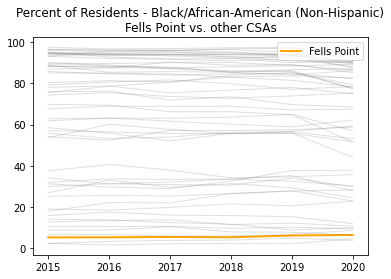

In [15]:
highlight_line_plot("paa", "Fells Point", year_after = 2015,
                    figsize = (8, 4), legend_loc = "upper right")

To do: add the final gif function

In [79]:
#### metafunction: view a static plot of an indicator, city wide, for a single year 
def baltimore_map(indicator, year, cmap = None):
  '''
  Takes a single indicator and a single year and plots a simple choropleth map of CSAs in Baltimore 
  ***
  indicator: string, indicator shortname as it appears in the data 
  year: string or numeric, year of data to show 
  '''
  # special subset option in the case of plotting 2006-2010 data 
  if year == "2006 - 2010":
    retain = True
  else: 
    retain = False
  mapdat = subset_vsg(indicator, retain_2006to2010= retain)

  # subset by year (numeric or string )
  if type(year) == int: 
    mapdat = mapdat[mapdat.year_numeric == year]
  else: 
    mapdat = mapdat[mapdat.year == year]
  # remove city-wide value
  mapdat = mapdat[mapdat.CSA != "Baltimore City"]

  # plot 
  title_text = mapdat.indicator_description.iloc[0] + ",\n" + str(year)
  fig, ax = plt.subplots(1,1)
  mapdat.plot("value", ax = ax, legend = True, cmap = None)
  ax.set_title(title_text)
  ax.set_axis_off()
  return plt.show()



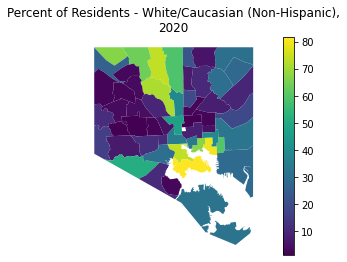

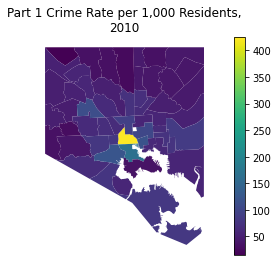

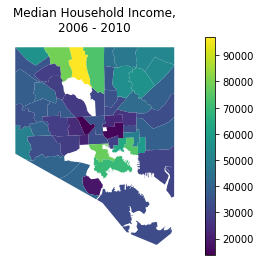

In [80]:
### some examples
baltimore_map("pwhite", 2020)
baltimore_map("crime", 2010)
baltimore_map("mhhi", "2006 - 2010")

In [ ]:
#### line plot: show the top, bottom, and middle CSAs per indicator 


In [ ]:
def highlight_line_plot(indicator,csa_of_interest, year_before = 2050, year_after = 1990,
                        figsize = (5,5), highlight_color = "orange",
                        legend_loc = "best", 
                        alpha = 0.25):
  '''
  Function to create a line plot with one highlighted line of interest 
  ***
  indicator: the shortname of the indicator of interest
  csa_of_interest: the CSA to be highlighted 
  year_before: filter to all years less than or equal to this year  (2050 as a placeholder)
  year_after: filter to all years greater than or equal to this year (1990 as a placeholder)
  figsize: dimensions of the figure 
  highlight_color: color of the line of interest 
  legened_loc: location of the legend 
  alpha: transparency level of the grey lines (default is 0.25)
  '''
  linpltdat = subset_vsg(indicator = indicator)
  # filter out NA values, filter to desired time frame 
  linpltdat = linpltdat[linpltdat.year_numeric.notna()]
  linpltdat = linpltdat[(linpltdat.year_numeric >= year_after) & (linpltdat.year_numeric <= year_before)]
  # grab indicator description 
  ind_desc = linpltdat.indicator_description.iloc[0]

  # plot line of interest
  csadat = linpltdat[linpltdat.CSA == csa_of_interest]
  plt.plot(csadat.year_numeric, csadat.value, label = csa_of_interest, color = highlight_color,
           linewidth = 2)

  ## plot all other lines
  # get list of all other CSAs
  other_csas = set(linpltdat.CSA)
  other_csas.remove(csa_of_interest)
  # loop through other csas
  for csa in other_csas: 
    lindat = linpltdat[linpltdat.CSA == csa] 
    plt.plot(lindat.year_numeric, lindat.value, label = None, 
             color = "grey", alpha = alpha, linewidth = 1) # grey out aesthetics

  # aesthetics 
  plt.legend(loc = legend_loc)
  title_text = ind_desc + "\n" + csa_of_interest + " vs. other CSAs"
  plt.title(title_text)
  xticks = list(set(linpltdat.year_numeric))
  plt.xticks(xticks)
  plt.rcParams["figure.figsize"] = figsize
  plt.show()

In [72]:
indicator = "mhhi"
year = "2006 - 2010"
mapdat = subset_vsg(indicator)
# if type(year) == int: 
#   mapdat = mapdat[mapdat.year_numeric == year]
# else: 
#   mapdat = mapdat[mapdat.year == year]
#mapdat = mapdat[mapdat.CSA != "Baltimore City"]


#title_text = mapdat.indicator_description.iloc[0] + ",\n" + str(year)
#fig, ax = plt.subplots(1,1)
#mapdat.plot("value", ax = ax, legend = True, cmap = None)
#ax.set_title(title_text)
#ax.set_axis_off()
#plt.show()
mapdat


,CSA,indicator,year,value,year_numeric,geometry,indicator_description
1119,Allendale/Irvington/S. Hilton,mhhi,2000,28042.6736,2000.0,"POLYGON ((-76.65726 39.27600, -76.65726 39.276...",Median Household Income
1120,Beechfield/Ten Hills/West Hills,mhhi,2000,38916.6930,2000.0,"POLYGON ((-76.69479 39.30201, -76.69465 39.301...",Median Household Income
1121,Belair-Edison,mhhi,2000,36512.3887,2000.0,"POLYGON ((-76.56761 39.32636, -76.56746 39.326...",Median Household Income
1122,Brooklyn/Curtis Bay/Hawkins Point,mhhi,2000,26357.8630,2000.0,"MULTIPOLYGON (((-76.58867 39.21283, -76.58824 ...",Median Household Income
1123,Canton,mhhi,2000,40234.6768,2000.0,"POLYGON ((-76.57140 39.28441, -76.57138 39.284...",Median Household Income
...,...,...,...,...,...,...,...
32637,Southwest Baltimore,mhhi,2019,27176.5981,2019.0,"POLYGON ((-76.65038 39.29375, -76.65000 39.293...",Median Household Income
32638,The Waverlies,mhhi,2019,42464.6233,2019.0,"POLYGON ((-76.59550 39.33416, -76.59548 39.334...",Median Household Income
32639,Upton/Druid Heights,mhhi,2019,21318.7970,2019.0,"POLYGON ((-76.63401 39.31045, -76.62509 39.303...",Median Household Income
32640,Washington Village/Pigtown,mhhi,2019,51593.5906,2019.0,"POLYGON ((-76.62096 39.27466, -76.62110 39.274...",Median Household Income
